In [ ]:
import gzip
import zipfile
import json
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import pandas as pd
import string
import random
import string
from sklearn import linear_model
import matplotlib.pyplot as plt
path = "../ref/"
path = "./data/"

In [ ]:
def getJason(fname):
    with open(fname, 'r', encoding="utf8") as fnfp:
        fndat1 = fnfp.read()
    try:
        fndat2 = json.loads(fndat1)
    except json.JSONDecodeError as err:
        fndat2 = 0
        print(f'Error decoding JSON: {err}')
    return fndat2

In [3]:
def getJason2(fname, maxno=-1):
    fndat2 = list()
    no = 0
    with open(fname, 'r') as json_file:
        for line_number, line in enumerate(json_file,1):
            try:
                imagerev_data = json.loads(line)
                fndat2.append(imagerev_data)
                no += 1
                if (maxno > -1) & (no >= maxno):
                    break
            except json.JSONDecodeError as err:
                print(f'Error decoding JSON: {err}')
        return fndat2

In [4]:
json_data = getJason(path+'filter_all_t.json')

In [5]:
json_data['train'][0]
# dictonary with unique on business_id , user_id keys value
# keeps rating, review text and
# 'history_reviews' : history of reviews given by this user in an 
# list of list  [ <uid>_<busid], <review text>]

{'business_id': '60567465d335d0abfb415b26',
 'user_id': '101074926318992653684',
 'rating': 4,
 'review_text': 'The tang of the tomato sauce is outstanding. And the crust is a meal, as it should be. Order a whole pie fresh.',
 'pics': ['AF1QipM-2IRmvitARbcJr7deWfe5hyVBg_ArPMQSYvq0',
  'AF1QipPWhe1OP80YPU40J6-XIdxbJIe57vKm8TTjve31',
  'AF1QipNuKWM65S9ZFQykvdIhKUliE6K1VBxssTUYyl8d',
  'AF1QipOJng1JS_1hmpfhAVrr7hE89dcoOtdy-Z6cOO9x'],
 'history_reviews': [['101074926318992653684_6056272797d555cc6fb0d147',
   'The pizza here is the real deal, perfect in every way except for the crust, which was more cracker crisp than chewy bread. Also recommend the meatball parmigiana hero, beefy, fluffy, overflowing, tangy, chunky tomato sauce, toothsome bread.'],
  ['101074926318992653684_604a65c2c6dc737bce7e5a3d',
   'Omg the tomato sauce is everything, in the meatball appetizer, pizza & as a dip for that scratch-made focaccia. Farm-fresh salad. A variety of artisan toppings. Ask for the chili oil! Goes

In [6]:
json_data.keys()

dict_keys(['train', 'val', 'test'])

In [7]:
[len(json_data[i]) for i in json_data.keys()]

[87013, 10860, 11015]

## Image review

In [8]:
iddat = getJason2(path+'image_review_all.json', 20*10000)

len(iddat), type(iddat)

(200000, list)

In [9]:
iddat[0:1]

[{'business_id': '605730f68cd0e3d69a52284b',
  'user_id': '113890892872599852766',
  'rating': 4,
  'review_text': 'We came for a birthday brunch and this place is so much bigger than it looks from the outside! It was totally packed and loud. Service was on the slower side. I ordered 2 mojitos: 1 lime and 1 mango. The ingredient weren’t really fresh, there wasn’t even any visible mango in the second one. Tasted like mango juice from concentrate. My food was really good though. I ordered the steak and eggs and I usually order my steak rare but this was skirt steak so they did a perfect medium. The sunny side up eggs were more cooked than I would have preferred but still good. They actually cooked the breakfast potatoes too, which was awesome. Will likely be back to try something else!',
  'pics': [{'id': 'AF1QipPrls2G30PS3tyC55KBxUrKgy3ER0AB5UJY57BZ',
    'url': ['https://lh5.googleusercontent.com/p/AF1QipPrls2G30PS3tyC55KBxUrKgy3ER0AB5UJY57BZ=w150-h150-k-no-p']},
   {'id': 'AF1QipOBdiu

In [10]:
# convert to data frame
df = pd.DataFrame(iddat)

In [11]:
df.head(1), df.shape, df.columns

(                business_id                user_id  rating  \
 0  605730f68cd0e3d69a52284b  113890892872599852766       4   
 
                                          review_text  \
 0  We came for a birthday brunch and this place i...   
 
                                                 pics  
 0  [{'id': 'AF1QipPrls2G30PS3tyC55KBxUrKgy3ER0AB5...  ,
 (200000, 5),
 Index(['business_id', 'user_id', 'rating', 'review_text', 'pics'], dtype='object'))

# Exploatory Analysis

## Histogram for distribution of no of records of rating for business 

In [12]:
dfgrpbusinesscnt = df.groupby('business_id').count()

Text(0.5, 1.0, 'Distribution of 9782 businesses on 200000 records')

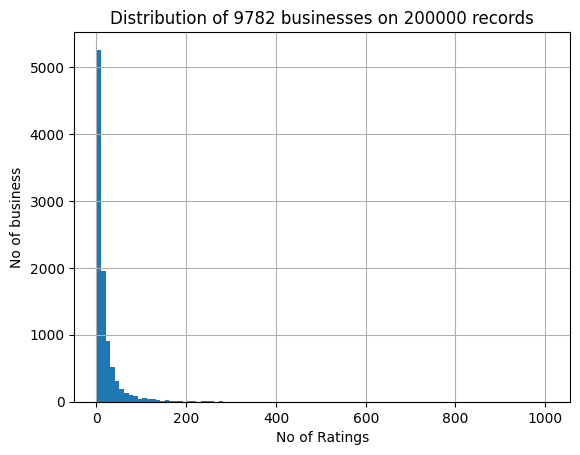

In [13]:
dfgrpbusinesscnt['user_id'].hist(bins=100)
#fig, ax = plt.subplots(figsize=(8, 8))
plt.xlabel('No of Ratings')
plt.ylabel('No of business')
plt.title(f'Distribution of {dfgrpbusinesscnt.shape[0]} businesses on {df.shape[0]} records')

In [14]:
len(df['user_id'].unique())

169380

## distribution of user comment 

<IPython.core.display.Javascript object>


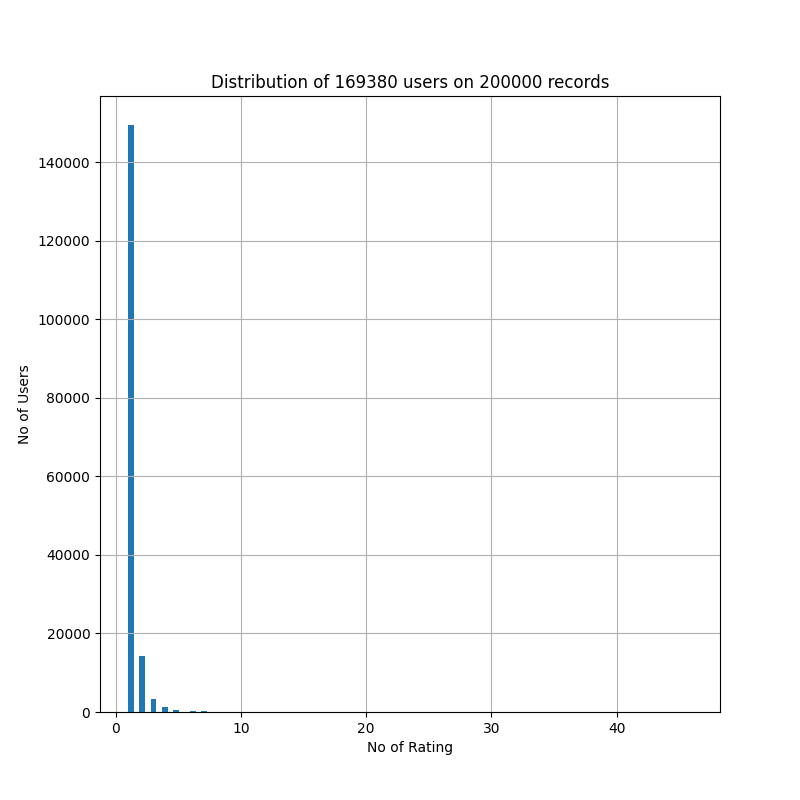

Text(0.5, 1.0, 'Distribution of 169380 users on 200000 records')

In [25]:
dfgrpusercnt = df.groupby('user_id').count()
fig, ax = plt.subplots(figsize=(8, 8))
dfgrpusercnt['business_id'].hist(bins=100)
plt.xlabel('No of Rating')
plt.ylabel('No of Users')
plt.title(f'Distribution of {dfgrpusercnt.shape[0]} users on {df.shape[0]} records')

## Distribution of rating 

In [26]:
dfgrpratingcnt = df.groupby('rating').count()
dfgrpratingcnt

,business_id,user_id,review_text,pics
rating,,,,
1,8557,8557,8557,8557
2,5440,5440,5440,5440
3,12140,12140,12140,12140
4,38638,38638,38638,38638
5,135225,135225,135225,135225


<IPython.core.display.Javascript object>


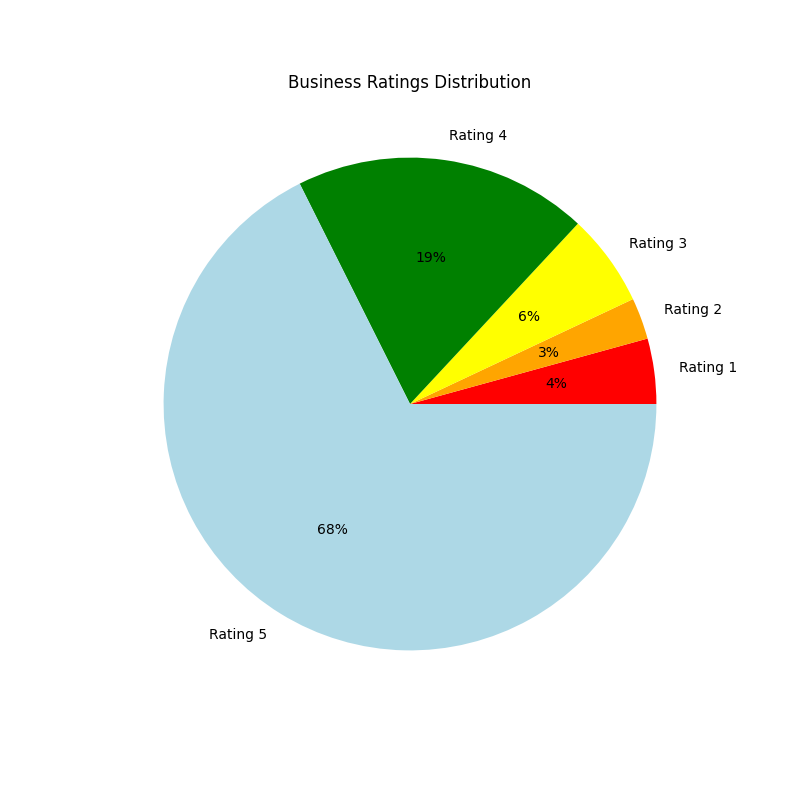

In [27]:
import matplotlib.pyplot as plt

ratings = list(dfgrpratingcnt['user_id'])
labels = ['Rating '+str(i)  for i in dfgrpratingcnt.index]
fig, ax = plt.subplots(figsize=(8, 8))
plt.pie(ratings, labels=labels, autopct='%1.0f%%', startangle=0, \
        colors=['red', 'orange', 'yellow', 'green', 'lightblue'])
plt.title('Business Ratings Distribution')
plt.show()

## Heatmap for user , business and rating

In [28]:
dfgrpuser=df.groupby('user_id')
dfgrpuser

In [29]:
cmcnt = 200
topusrcnt = cmcnt
topbuscnt = cmcnt

topusr = dfgrpusercnt['business_id'].\
            sort_values(ascending=False)[0:topusrcnt].index

topusr[0:10]


topbus = dfgrpbusinesscnt['user_id'].\
            sort_values(ascending=False)[0:topbuscnt].index

In [30]:
rdatal = list()
for u in topusr:
    bdatal = list()
    grp = dfgrpuser.get_group(u)[['business_id', 'rating']]
    #grp['business_id']=grp['business_id'].astype(str)
    #grp=pd.Series(grp['rating'], index=grp['business_id'])
    #grp.name = None
    grp = dict(zip(grp['business_id'], grp['rating']))
    #print(grp)
    for b in topbus:
        #print(b, b in grp.index)
        if b in grp:
            #print(f'putting val {grp[b]=}')
            bdatal.append(grp[b])
        else:
            bdatal.append(0)
    rdatal.append(bdatal)
    #break
#rdatal

In [31]:
from matplotlib.colors import LinearSegmentedColormap
#plt.cm.RdYlGn
cmap1 = LinearSegmentedColormap.from_list('custom_white', ['beige', 'red', 'blue'])
# bone_r

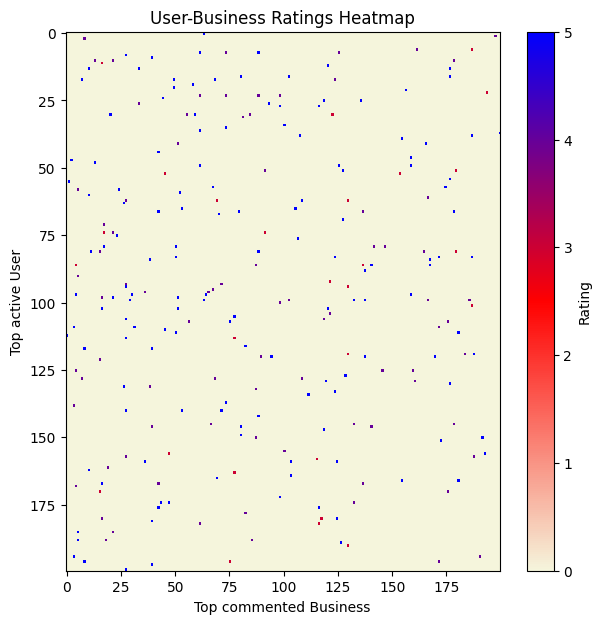

In [75]:
#%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,7))
# Sample data: user-business ratings
# Replace this with your actual data
ratings_data = np.array(rdatal)
#plt.cm.RdYlGn
plt.imshow(ratings_data, cmap=cmap1, interpolation='nearest',\
           aspect='auto', vmin=0, vmax=5)
cbar = plt.colorbar(ticks=np.arange(0, 6), label='Rating')
plt.xlabel('Top commented Business')
plt.ylabel('Top active User')
plt.title('User-Business Ratings Heatmap')
plt.show()

## Splitting data into validation 

In [33]:
valpc = .05
testpc = .1
trainpc = 1 - testpc - valpc

In [34]:
def splitdf(df):
    traindf = df.iloc[:int(trainpc*df.shape[0]), :]
    valdf = df.iloc[int(trainpc*df.shape[0]):int((valpc+trainpc)*df.shape[0]), :]
    testdf = df.iloc[int((valpc+trainpc)*df.shape[0]):, :]
    print(f'{traindf.shape, valdf.shape, testdf.shape}')
    return traindf, valdf, testdf


traindf, valdf, testdf = splitdf(df)

((170000, 5), (10000, 5), (20000, 5))


In [35]:
def splitlist(l):
    nl = len(l)
    trainl = l[:int(trainpc*nl)]
    vall =   l[int(trainpc*nl):int((valpc+trainpc)*nl)]
    testl =  l[int((valpc+trainpc)*nl):]
    return trainl, vall, testl

# Model
## Baseline Model

In [36]:
def GetDataAccuracy(df, matchser, missval=0):
    ids = df['business_id'].astype(str)
    matlst = dict(matchser)
    #print(f'{matlst.keys()}')
    #print(matlst)
    def fnid(id):
        if str(id) in matlst:
            return matlst[id]
        else:
            #print(f'{id} not found')
            return round(missval)
    preds = [fnid(id) for id in ids]
    y = df['rating']
    cor = y == preds
    acc = sum(cor)/ len(cor)
    return acc

In [37]:
business_means = traindf.groupby('business_id')['rating'].mean()

## Baseline Model : Hyperparameter selection 

In [38]:
misvalue = traindf['rating'].mean()
m0acc1 = GetDataAccuracy(valdf, business_means, missval=misvalue)
print(f'Validation accuracy using missing value as mean of training data \
{misvalue} on test data is {m0acc1}')

Validation accuracy using missing value as mean of training data 4.438788235294117 on test data is 0.1937


In [39]:
from statistics import mode
misvalue = traindf['rating'].mode()[0]
m0acc2 = GetDataAccuracy(valdf, business_means, missval=misvalue)
print(f'Validation accuracy using missing value as mode of training data \
{misvalue} on test data is {m0acc2}')

Validation accuracy using missing value as mode of training data 5 on test data is 0.6561


## Baseline Model : Test accuracy 

In [40]:
misvalue = traindf['rating'].mode()[0]
m0acct = GetDataAccuracy(testdf, business_means, missval=misvalue)
print(f'Test accuracy using missing value as mode of training data \
{misvalue} on test data is {m0acct}')

Test accuracy using missing value as mode of training data 5 on test data is 0.6683


In [41]:
modlst = list()
modlst.append((m0acct, 'Baseline Model', \
               [2, (m0acc1, 'Using Mean of training data for missing value'),\
                   (m0acc2, 'Using Mode of training data for Missing value')]\
              ))

## Model 1 : Alternating Least Square Model

In [42]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

In [43]:
users = df.groupby('user_id')[['rating']].mean()\
    .reset_index().reset_index().set_index('user_id')
df['u_index'] = df['user_id'].apply(lambda x: users.loc[x]\
                        ['index'].astype(np.int32))
business_means1 = df.groupby('business_id')['rating'].mean()
businesses = pd.DataFrame(business_means1).reset_index().reset_index().set_index('business_id')
df['b_index'] = df['business_id'].apply(lambda x: businesses.loc[x]['index'].astype(np.int32))
traindf, valdf, testdf = splitdf(df)

((170000, 7), (10000, 7), (20000, 7))


In [44]:
#create sparse matrix
matrix = csr_matrix(
    (traindf['rating'].astype(np.float32),
    (traindf['u_index'], traindf['b_index'])),
    shape=(len(users), len(businesses)
))

In [ ]:
m1 = AlternatingLeastSquares()
m1.fit(matrix)

In [ ]:
user_indices = testdf['u_index'].unique()
business_indices = testdf['b_index'].unique()

In [ ]:
matrix.T

In [ ]:
matrix

In [ ]:
N = len(business_indices)
recommendations = m1.recommend(user_indices[0], user_items=matrix.T, N=N)
predicted_business_indices, predicted_scores = zip(*recommendations)
predicted_ratings = np.zeros_like(business_indices, dtype=float)
predicted_ratings[np.array(predicted_business_indices)] = predicted_scores

In [ ]:
preds = predictions.flatten()
actual = test_matrix.data

## Model 2 : SVD 

In [45]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import GridSearchCV

In [46]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'business_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25, random_state=100)

In [47]:
#dfsel = df[['user_id', 'business_id', 'rating']]
#traindf, valdf, testdf = splitdf(dfsel)
#collst = ['user_id', 'business_id', 'rating']
#traindfds = Dataset.load_from_df(traindf, reader)
#valdfds = Dataset.load_from_df(valdf, reader)
#testdfds = Dataset.load_from_df(testdf, reader)

In [48]:
model = SVD()
model.fit(trainset)

In [49]:
predictions = model.test(testset)
mse = accuracy.mse(predictions)
print(f'Mean Squared Error: {mse}')

preds_ratings = [round(pred.est) for pred in predictions]
test_ratings = np.array([x[2] for x in testset])
correct = np.array(preds_ratings) == np.array(test_ratings)
m2acc = sum(correct) / len(correct)
m2acc

MSE: 0.9483
Mean Squared Error: 0.9482544129895496


0.50484

In [50]:
modlst.append((m2acc, 'SVD Model', [0, ]))
modlst

[(0.6683,
  'Baseline Model',
  [2,
   (0.1937, 'Using Mean of training data for missing value'),
   (0.6561, 'Using Mode of training data for Missing value')]),
 (0.50484, 'SVD Model', [0])]

## Model 3 : Logistic Regression of feature as tf-idf

### Prediction of rating on review comments

In [51]:
def gettf(str,  tf=0, islower=True, ispunc = True, isadd=True, punc=0):
    lwr = lambda x : x.lower()
    if islower == False:
        lwr = lambda x: x
    thistf = {}
    if(tf == 0):
        tf = defaultdict(int)
    frmtstr =''
    if ispunc == True:
        if punc == 0:
            punc = set(string.punctuation)
        frmtstr = ''.join([lwr(c) for c in str if not lwr(c) in punc])
    else:
        frmtstr = ''.join([lwr(c) for c in str])
    for w in frmtstr.split():
        if isadd == True:
            tf[w] += 1
        else:
            if w not in thistf:
                tf[w] += 1
                thistf[w]=1
    return tf




# creating design matrix
def feature(datum, words, wordId, isVector=True, tolower=True, removePunct=True):
    feat = [0]*len(words)
    r = datum#['text']
    # get lcl tf for this
    lcltf = gettf(r, 0, True, True, True)
    if tolower:
        r = r.lower()
    if removePunct:
        r = ''.join([c for c in r if c not in punc])
    for w in r.split():
        if w in words:
            if isVector == False:
                feat[wordId[w]] += idf[w]*lcltf[w]
            else:
                feat[wordId[w]] = idf[w]*lcltf[w]
    # if vector then not intended to be used in X matrix.but for cosine similarity
    if isVector == False:
        feat.append(1) # offset
    return feat



In [52]:
# getting most frequent words
trtf = defaultdict(int)
punc = string.punctuation
df['review_text'].apply(lambda x : gettf(x, \
                            trtf, islower=True, \
                                ispunc = True, isadd=True,
                                              punc=punc))


0         {'we': 65994, 'came': 10635, 'for': 93656, 'a'...
1         {'we': 65994, 'came': 10635, 'for': 93656, 'a'...
2         {'we': 65994, 'came': 10635, 'for': 93656, 'a'...
3         {'we': 65994, 'came': 10635, 'for': 93656, 'a'...
4         {'we': 65994, 'came': 10635, 'for': 93656, 'a'...
                                ...                        
199995    {'we': 65994, 'came': 10635, 'for': 93656, 'a'...
199996    {'we': 65994, 'came': 10635, 'for': 93656, 'a'...
199997    {'we': 65994, 'came': 10635, 'for': 93656, 'a'...
199998    {'we': 65994, 'came': 10635, 'for': 93656, 'a'...
199999    {'we': 65994, 'came': 10635, 'for': 93656, 'a'...
Name: review_text, Length: 200000, dtype: object

In [53]:
# sorting
swcntset = [(trtf[i], i) for i in trtf]
swcntset.sort(reverse=True)
swcnt = [i[1] for i in swcntset]
swcntset[0:10]

[(432702, 'the'),
 (313906, 'and'),
 (192172, 'a'),
 (185034, 'was'),
 (154581, 'to'),
 (152498, 'i'),
 (115537, 'is'),
 (109500, 'food'),
 (103650, 'of'),
 (96836, 'it')]

In [54]:
def getidf(iter, fn, issorted=False, islog10=True, islower=True, ispunc=True, punc=0):
    idx = 0
    df = defaultdict(int)
    for x in iter:
        x = fn(x)
        idx += 1
        #print(f'{idx=} : {x}')
        gettf(x, df, islower, ispunc, isadd=False, punc=punc)
    print(f'total entries:{idx}')
    oplst = []
    for k in df.keys():
        if islog10 == True:
            logfn = math.log10
        else:
            logfn = math.log2
        df[k] = logfn(idx/df[k])
        if issorted == True:
            #print(df[k], k)
            oplst.append((df[k], k))
    # if sorted
    if (issorted == True):
        oplst.sort(reverse=True)
    return df, oplst

# get idf for words
idf, oplst = getidf(df['review_text'], lambda x: x)

total entries:200000


In [55]:
len(swcntset)

126867

In [56]:
def getModAccuracy(c, Xtrain, Ytrain, Xval, Yval, slvr='lbfgs'):
    mod = linear_model.LogisticRegression(C=c, solver=slvr)
    modop=mod.fit(Xtrain, Ytrain)
    yval = mod.predict(Xval)
    correct = yval == Yval
    accuracy = sum(correct)/len(correct)
    print(f'{c, accuracy=}')
    return mod, accuracy

In [57]:
def GetBestModAccuracy(nw):
   words = [i[1] for i in swcntset[0:nw]]
   wordId = dict(zip(words, range(len(words))))
   X = list(df['review_text'].apply(lambda x : \
                        feature(x, words, wordId)))
   Y = list(df['rating'])
   Xtrain, Xval, Xtest = splitlist(X)
   Ytrain, Yval, Ytest = splitlist(Y)
   # validation on the selecting hyperparameter
   #cList = [1, 2, 5, 6, 0.5, 7, .25]
   cList = [5, 7]
   accList = list()
   for c in cList:
      mod, acc = getModAccuracy(c, Xtrain, Ytrain, Xval, Yval)
      accList.append((acc, c, mod))
   accList.sort(reverse=True)
   print(accList)
   c=accList[0][1]
   print(f'{c=}')
   mod, acc = getModAccuracy(c, Xtrain, Ytrain, Xtest, Ytest)
   return mod, acc, c, accList



In [58]:
nwlst = [500, 750]
nwlstop = list()
for nw in nwlst:
    mod, acc, c, acclst = GetBestModAccuracy(nw)
    nwlstop.append((acc, nw, c, acclst, mod))

C:\Users\mail2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c, accuracy=(5, 0.7159)


C:\Users\mail2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c, accuracy=(7, 0.7155)
[(0.7159, 5, LogisticRegression(C=5)), (0.7155, 7, LogisticRegression(C=7))]
c=5


C:\Users\mail2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c, accuracy=(5, 0.72755)


C:\Users\mail2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c, accuracy=(5, 0.7222)


C:\Users\mail2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c, accuracy=(7, 0.7224)
[(0.7224, 7, LogisticRegression(C=7)), (0.7222, 5, LogisticRegression(C=5))]
c=7


C:\Users\mail2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c, accuracy=(7, 0.73135)


In [59]:
nwlstop.sort(reverse=True)
nwlstop

[(0.73135,
  750,
  7,
  [(0.7224, 7, LogisticRegression(C=7)), (0.7222, 5, LogisticRegression(C=5))],
  LogisticRegression(C=7)),
 (0.72755,
  500,
  5,
  [(0.7159, 5, LogisticRegression(C=5)), (0.7155, 7, LogisticRegression(C=7))],
  LogisticRegression(C=5))]

In [60]:
#[(0.7193, 320, 6, LogisticRegression(C=6)),
# (0.71785, 310, 6, LogisticRegression(C=6)),
# (0.71695, 300, 6, LogisticRegression(C=6))]

#[(0.72315, 390, 7, LogisticRegression(C=7)),
# (0.72145, 360, 7, LogisticRegression(C=7)),
# (0.71945, 330, 6, LogisticRegression(C=6))]

#[(0.73135, 750, 7, LogisticRegression(C=7)),
# (0.73035, 700, 7, LogisticRegression(C=7)),
# (0.73035, 650, 7, LogisticRegression(C=7)),
# (0.7296, 600, 7, LogisticRegression(C=7)),
# (0.72815, 550, 5, LogisticRegression(C=5)),
# (0.72755, 500, 5, LogisticRegression(C=5)),
# (0.72615, 450, 7, LogisticRegression(C=7)),
#(0.72315, 400, 5, LogisticRegression(C=5))]

In [61]:
modlst

[(0.6683,
  'Baseline Model',
  [2,
   (0.1937, 'Using Mean of training data for missing value'),
   (0.6561, 'Using Mode of training data for Missing value')]),
 (0.50484, 'SVD Model', [0])]

In [64]:
for r in nwlstop:
    s = (r[0], 'LogisticRegression_vector'+str(r[1])+'_c'+str(r[2]), [0])
    modlst.append(s)

In [65]:
modlst

[(0.6683,
  'Baseline Model',
  [2,
   (0.1937, 'Using Mean of training data for missing value'),
   (0.6561, 'Using Mode of training data for Missing value')]),
 (0.50484, 'SVD Model', [0]),
 (0.73135, 'LogisticRegression_vector750_c7', [0]),
 (0.72755, 'LogisticRegression_vector500_c5', [0])]

# Summary Plot 

In [68]:
sumser = pd.Series([i[0] for i in modlst], index=[i[1] for i in modlst])
sumser

Baseline Model                     0.66830
SVD Model                          0.50484
LogisticRegression_vector750_c7    0.73135
LogisticRegression_vector500_c5    0.72755
dtype: float64

Text(0.5, 1.0, 'Comparison of Test Accuracy for various Models')

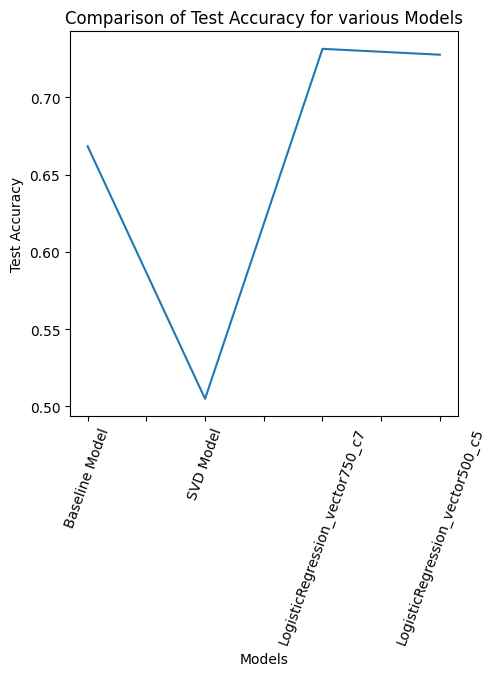

In [79]:
fig, ax = plt.subplots(figsize=(5,5))
sumser.plot()
plt.xlabel('Models')
plt.xticks(rotation=70)
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracy for various Models')